In [2]:
!pip install -q -U transformers==4.53.3 num2words

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 7.4 MB/s eta 0:00:00


# Library code, modified

MQT Q-Former from https://github.com/gordonhu608/MQT-LLaVA

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.init import trunc_normal_
import math
from functools import partial
import numpy as np
import random

def get_matry_n(num_visual_tokens):
    if num_visual_tokens == 'first_stage':
        return 729
    elif num_visual_tokens == 'second_stage':
        matry_list = range(1, 730, 4)
        return random.choice(matry_list)

    try:
        num_visual_tokens = int(num_visual_tokens)
        if 1 <= num_visual_tokens <= 729:
            return num_visual_tokens
    except (ValueError, TypeError):
        print('The num_visual_tokens is should be an integer between 1 and 729')

    raise ValueError(f"Invalid input: {num_visual_tokens}")

def get_abs_pos(abs_pos, tgt_size):
    # abs_pos: L, C
    # tgt_size: (H, W)
    # return: M, C
    src_size = int(math.sqrt(abs_pos.size(0)))
    # tgt_size = int(math.sqrt(tgt_size))
    dtype = abs_pos.dtype
    return F.interpolate(
        abs_pos.float().reshape(1, src_size, src_size, -1).permute(0, 3, 1, 2),
        size=(tgt_size[0], tgt_size[1]),
        mode="bicubic",
        align_corners=False,
    ).permute(0, 2, 3, 1).flatten(0, 2).to(dtype=dtype)


# https://github.com/facebookresearch/mae/blob/efb2a8062c206524e35e47d04501ed4f544c0ae8/util/pos_embed.py#L20
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])


    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float32)
    omega /= embed_dim / 2.
    omega = 1. / 10000 ** omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


class Resampler(nn.Module):
    """
    A 2D perceiver-resampler network with one cross attention layers by
        (grid_size**2) learnable queries and 2d sincos pos_emb
    Outputs:
        A tensor with the shape of (grid_size**2, embed_dim)
    """

    def __init__(
            self,
            grid_size,
            embed_dim,
            num_heads,
            kv_dim=None,
            norm_layer=partial(nn.LayerNorm, eps=1e-6)
    ):
        super().__init__()
        self.num_queries = grid_size ** 2
        self.embed_dim = embed_dim
        self.num_heads = num_heads

        self.pos_embed = nn.Parameter(
            torch.from_numpy(get_2d_sincos_pos_embed(kv_dim, grid_size)).to(torch.bfloat16)
        ).requires_grad_(False)

        self.query = nn.Parameter(torch.zeros(self.num_queries, kv_dim)).to(torch.bfloat16)
        trunc_normal_(self.query, std=.02)

        self.attn = nn.MultiheadAttention(kv_dim, num_heads).to(device = "cuda:0", dtype=torch.bfloat16)

        self.ln_q = norm_layer(kv_dim).to(device = "cuda:0", dtype=torch.bfloat16)
        self.ln_k = norm_layer(kv_dim).to(device = "cuda:0", dtype=torch.bfloat16)
        self.ln_v = norm_layer(kv_dim).to(device = "cuda:0", dtype=torch.bfloat16)

        # self.ln_post = norm_layer(kv_dim)
        self.proj = nn.Parameter((embed_dim ** -0.5) * torch.randn(kv_dim, embed_dim)).to(device="cuda:0", dtype=torch.bfloat16)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x, num_visual_tokens=256, tgt_size=(24,24), attn_mask=None):
        pos_embed = get_abs_pos(self.pos_embed, tgt_size)

        x = x.permute(1, 0, 2)  # x: (seq_len, batch_size, dim)
        B = x.shape[1]  # true batch size


        matry_n = get_matry_n(num_visual_tokens)
        q = self.query[:matry_n]  # (matry_n, dim)
        q = self._repeat(q, B)    # (matry_n, B, dim)

        k = self._repeat(pos_embed, B).to(device = "cuda:0", dtype=torch.bfloat16)
        v = x
        q= q.to(device = "cuda:0")
        # self.pos_embed = self.pos_embed.to(device = "cuda:0")
        # print(q.dtype)
        # print(k.dtype)
        # print(v.dtype)
        # print (self.pos_embed.dtype)
        q = self.ln_q(q + self.pos_embed[:matry_n].unsqueeze(1).to(device = "cuda:0")).to(device = x.device ,dtype=torch.bfloat16)
        k = self.ln_k(k).to(device = x.device ,dtype=torch.bfloat16)
        v = self.ln_v(v).to(device = x.device ,dtype=torch.bfloat16)

        out = self.attn(q, k, v, attn_mask=attn_mask)[0]  # (matry_n, B, dim)


        x = out.permute(1, 0, 2)

        x = x @ self.proj
        # print(x.shape)
        return x

    def _repeat(self, query, N: int):
        return query.unsqueeze(1).repeat(1, N, 1)

In [3]:
class MultiResampler(nn.Module):
    """
    experimental multi-resampler

    Args:
        num_resamplers:int = number of resamplers(qformers)

    Outputs:
        A tensor with the shape of (grid_size**2, embed_dim)
    """

    def __init__(
            self,
            grid_size,
            embed_dim,
            num_heads,
            num_resamplers,
            kv_dim=None,
            norm_layer=partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        self.resamplers = [Resampler(grid_size, embed_dim, num_heads, kv_dim, norm_layer) for _ in range(num_resamplers)]

    def _init_weights(self, m):
        for i in  range(len(self.resamplers)):
            self.resamplers[i]._init_weights(m)

    def forward(self, x, num_visual_tokens=256, tgt_size=(27,27), attn_mask=None):
        # raise NotImplementedError()
        # x should be a list
        assert len(x) == len(self.resamplers)

        num_vt_each = num_visual_tokens//len(self.resamplers)
        outs = []
        for i in range(len(self.resamplers)):
            outs.append(self.resamplers[i].forward(x[i], num_vt_each, tgt_size))
        concat = torch.cat(outs, dim=1)
        return concat

# Load Model

In [1]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText
from PIL import Image
import num2words

model_path = "HuggingFaceTB/SmolVLM2-2.2B-Instruct"

processor = AutoProcessor.from_pretrained(model_path)
model = AutoModelForImageTextToText.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    device_map="cuda",
)

for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/868 [00:00<?, ?B/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.03G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

In [ ]:
# Total trainable params
sum(p.numel() for p in model.parameters() if p.requires_grad)

2246784880

In [ ]:
# Vision trainable params
sum(p.numel() for p in model.model.vision_model.parameters() if p.requires_grad)

412987248

In [ ]:
# conversation = [
#     {
#         "role": "user",
#         "content": [
#             {"type": "image", "url": "sample.png"},
#             {"type": "text", "text": "Describe this image."}
#         ]
#     }
# ]

# inputs = processor.apply_chat_template(
#     conversation,
#     add_generation_prompt=True,
#     tokenize=True,
#     return_dict=True,
#     return_tensors="pt"
# ).to(model.device, dtype=torch.bfloat16)

# output_ids = model.generate(**inputs, max_new_tokens=128)
# generated_texts = processor.batch_decode(output_ids, skip_special_tokens=True)
# generated_texts

# Q-Former

In [4]:
qformer_config = {
    "grid_size": 27,
    "embed_dim": 1152,
    "num_heads": 16,
    "num_resamplers": 1,
    "kv_dim": 1152
}

In [23]:
import torch
x = torch.ones(6, 3, 32, 32)
y = torch.zeros(6, 3, 32, 32)
z = torch.cat([x, y], dim=0)
z = z.view(2, 6, 3, 32, 32)
z[:, 0, :, :, :].shape

torch.Size([2, 3, 32, 32])

In [ ]:
import torch
import torch.nn as nn
from transformers import ViTModel, AutoImageProcessor
from transformers.modeling_outputs import BaseModelOutput
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from torchvision.transforms import functional as F_transforms

class MultiCropVisionEncoder(nn.Module):
    def __init__(self, qformer_config, vision_tower):
        super().__init__()
        self.num_resamplers = qformer_config["num_resamplers"]
        self.embed_dim = qformer_config["embed_dim"]
        self.grid_size = qformer_config["grid_size"]

        self.vision_tower = vision_tower
        vision_hidden_size = self.vision_tower.config.hidden_size
        self.vision_tower_image_size = self.vision_tower.config.image_size

        self.vision_proj = nn.Linear(vision_hidden_size, self.embed_dim)

        self.multi_resampler = MultiResampler(
            grid_size=qformer_config["grid_size"],
            embed_dim=qformer_config["embed_dim"],
            num_heads=qformer_config["num_heads"],
            num_resamplers=qformer_config["num_resamplers"],
            kv_dim=qformer_config["kv_dim"],
            norm_layer=partial(nn.LayerNorm, eps=1e-6),
        )

    def forward(self, pixel_values, patch_attention_mask=None):
        pixel_values = pixel_values.to(torch.bfloat16)
        b4, c, h, w = pixel_values.shape
        assert b4 % self.num_resamplers == 0, "Batch size must be divisible by number of resamplers"
        batch_size = b4 // self.num_resamplers

        # image = np.transpose(pixel_values[0].cpu().numpy(), (1, 2, 0))
        # plt.imshow(image / 255.0)
        # plt.show()

        pixel_values = pixel_values.view(batch_size, self.num_resamplers, c, h, w)
        patch_embeddings_list = []
        for i in range(self.num_resamplers):
            sub_batch = pixel_values[:, i, :, :, :]

            resized_sub_batch = F_transforms.resize(sub_batch, size=(432, 432))


            vision_outputs = self.vision_tower(pixel_values=resized_sub_batch, interpolate_pos_encoding=True)
            embeddings = vision_outputs.last_hidden_state

            embeddings = embeddings.to(torch.bfloat16)

            embeddings = embeddings[:, 1:, :]
            embeddings = self.vision_proj(embeddings)

            patch_embeddings_list.append(embeddings)

        patch_embeddings = torch.stack(patch_embeddings_list, dim=1)

        # print(patch_embeddings.shape)
        x_list = list(patch_embeddings.unbind(dim=1))
        out = self.multi_resampler(x_list, num_visual_tokens=self.grid_size**2 * self.num_resamplers)

        out = out.view(batch_size * self.num_resamplers, self.grid_size**2, self.embed_dim).to(
            device=pixel_values.device,
            dtype=torch.bfloat16
        )
        # print(out.shape)
        return BaseModelOutput(last_hidden_state=out)

## Test Vision Encoder

In [6]:
vision_tower = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to(device= "cuda:0", dtype=torch.bfloat16)
test_vm = MultiCropVisionEncoder(qformer_config, vision_tower)
test_vm = test_vm.to(device= "cuda", dtype=torch.bfloat16)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [7]:
dummy_image = torch.randn(1, 3, 384, 384).to(device="cuda", dtype=torch.bfloat16)
output = test_vm(dummy_image)
print(output.last_hidden_state.shape)

torch.Size([1, 729, 1152])


In [8]:
sum(p.numel() for p in test_vm.parameters() if p.requires_grad)

87275136

# Integration

## loading the test image

In [9]:
from PIL import Image
image = Image.open("sample.png")

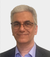

In [10]:
base_width = 50
w_percent = (base_width / float(image.size[0]))
h_size = int((float(image.size[1]) * float(w_percent)))
resized_image = image.resize((base_width, h_size), Image.Resampling.LANCZOS)

display(resized_image)

## modifying model config to support new vision model

In [9]:
old_config = model.config.vision_config

In [10]:
from transformers import PretrainedConfig

class Config(PretrainedConfig):
    model_type = "smolvlm_vision"

    def __init__(self, **kwargs):
        self.attention_dropout = 0.0
        self.hidden_act = "gelu_pytorch_tanh"
        self.hidden_size = 1152
        self.image_size = 384
        self.initializer_range = 0.02
        self.intermediate_size = 4304
        self.layer_norm_eps = 1e-06
        self.max_image_size = {"longest_edge": 384}
        self.num_attention_heads = 16
        self.num_channels = 3
        self.num_hidden_layers = 27
        self.patch_size = 14
        self.size = {"longest_edge": 1920}
        self.tie_word_embeddings = False
        self.torch_dtype = "bfloat16"
        self.transformers_version = "4.55.0"
        self.use_base_siglip = False

        self.grid_size = 27
        self.embed_dim = 1152
        self.num_heads = 16
        self.num_resamplers = 4
        self.kv_dim = 1152

        super().__init__(**kwargs)

## swapping vision model

the commented codes below are used to check the inner dimensions of the original and new model. not removed in case further debugging is needed.

In [11]:
old_vision_model = model.model.vision_model

In [ ]:
model.model.vision_model = None

In [ ]:
vision_tower = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
vision_tower.embeddings.patch_embeddings = vision_tower.embeddings.patch_embeddings.to(torch.bfloat16)
model.model.vision_model = MultiCropVisionEncoder(qformer_config, vision_tower).to(device=model.device, dtype=torch.bfloat16)
model.config.vision_config = Config()

In [ ]:
sum(p.numel() for p in model.model.vision_model.parameters() if p.requires_grad)

87275136

In [ ]:
# dummy = torch.randn(1, 3, 384,384).to(device="cpu", dtype=torch.bfloat16)
# old_vision_model = old_vision_model.to("cpu")
# old_vision_model(dummy).last_hidden_state.shape

torch.Size([1, 729, 1152])

In [11]:
processor.image_processor.max_image_size["longest_edge"]= 384
processor.image_processor.do_image_splitting=False
processor.image_processor.do_resize=True

## testing new model inference for errors

In [4]:
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": resized_image},
            # {"type": "image", "url": resized_image},
            # {"type": "image", "url": resized_image},
            # {"type": "image", "url": resized_image},
            {"type": "text", "text": "describe this image."}
        ]
    }
]

inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device, dtype=torch.bfloat16)

output_ids = model.generate(**inputs, max_new_tokens=32)
generated_texts = processor.batch_decode(output_ids, skip_special_tokens=True)
generated_texts

['User:\n\n\n\n\ndescribe this image.\nAssistant: The image depicts a man with gray hair and glasses. He is wearing a dark suit jacket over a light blue shirt. The man is smiling and looking directly at']

In [ ]:
model.model.vision_model

MultiCropVisionEncoder(
  (patch_embed): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14))
  (multi_resampler): MultiResampler()
)

# Save in huggingface

In [ ]:
!pip install -q huggingface_hub

In [ ]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText
from huggingface_hub import notebook_login, create_repo, upload_folder
import os

notebook_login()

In [ ]:
model = model.to("cuda")

In [ ]:
model_name = "SmolDriver"
hf_username = "ArianFiroozi"
repo_id = f"{hf_username}/{model_name}"
save_directory = f"./{model_name}"

model.save_pretrained(save_directory)
model.config.save_pretrained(save_directory)
processor.save_pretrained(save_directory)

['./SmolDriver/processor_config.json']

In [ ]:
from transformers import AutoModelForImageTextToText, AutoProcessor

model.push_to_hub("ArianFiroozi/SmolDriver", safe_serialization=True)
# processor.save_pretrained("SmolDriver", push_to_hub=True, repo_id="ArianFiroozi/SmolDriver")

README.md:   0%|          | 0.00/89.0 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


model.safetensors:   0%|          | 0.00/4.02G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ArianFiroozi/SmolDriver/commit/1f00ddda9f01861975e81a002c9fa74988d60bdb', commit_message='Upload SmolVLMForConditionalGeneration', commit_description='', oid='1f00ddda9f01861975e81a002c9fa74988d60bdb', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ArianFiroozi/SmolDriver', endpoint='https://huggingface.co', repo_type='model', repo_id='ArianFiroozi/SmolDriver'), pr_revision=None, pr_num=None)

In [ ]:
from transformers import AutoProcessor, AutoModelForImageTextToText

test_model = AutoModelForImageTextToText.from_pretrained("ArianFiroozi/SmolDriver",
                                                         torch_dtype=torch.bfloat16,
                                                         device_map="cuda")
test_processor = AutoProcessor.from_pretrained("ArianFiroozi/SmolDriver")

Some weights of the model checkpoint at ArianFiroozi/SmolDriver were not used when initializing SmolVLMForConditionalGeneration: ['model.vision_model.vision_proj.bias', 'model.vision_model.vision_proj.weight', 'model.vision_model.vision_tower.embeddings.cls_token', 'model.vision_model.vision_tower.embeddings.patch_embeddings.projection.bias', 'model.vision_model.vision_tower.embeddings.patch_embeddings.projection.weight', 'model.vision_model.vision_tower.embeddings.position_embeddings', 'model.vision_model.vision_tower.encoder.layer.0.attention.attention.key.bias', 'model.vision_model.vision_tower.encoder.layer.0.attention.attention.key.weight', 'model.vision_model.vision_tower.encoder.layer.0.attention.attention.query.bias', 'model.vision_model.vision_tower.encoder.layer.0.attention.attention.query.weight', 'model.vision_model.vision_tower.encoder.layer.0.attention.attention.value.bias', 'model.vision_model.vision_tower.encoder.layer.0.attention.attention.value.weight', 'model.vision_

In [ ]:
test_model.model.vision_model = test_model.model.vision_model.to(torch.bfloat16)

In [ ]:
import torch

conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": resized_image},
            {"type": "image", "url": resized_image},
            {"type": "image", "url": resized_image},
            {"type": "image", "url": resized_image},
            {"type": "text", "text": "describe this image."}
        ]
    }
]
inputs = test_processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
)

# Move all input tensors to the model's device
inputs = {k: v.to(test_model.device) if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}

output_ids = test_model.generate(**inputs, max_new_tokens=32)
generated_texts = test_processor.batch_decode(output_ids, skip_special_tokens=True)
generated_texts

RuntimeError: Expected bias to have type Float but got BFloat16

# knowledge transfer to vision model

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

in_channels = 3
out_channels = 1
input_shape = (3, 384, 384)
output_shape = (1, 729, 1152)

epochs = 3
batch_size = 4
num_samples = 1000
lr = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
class MockImageDataset(Dataset):
    def __init__(self, n_samples, in_shape, out_shape):
        self.n = n_samples
        self.in_shape = in_shape
        self.out_shape = out_shape
        self.data = torch.randn(n_samples, *in_shape)
        self.labels = torch.randn(n_samples, *out_shape)
    def __len__(self):
        return self.n
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [13]:
teacher = model.model.vision_model
student = test_vm

In [16]:
for p in teacher.parameters():
    p.requires_grad = False

print(f"Teacher params: {sum(p.numel() for p in teacher.parameters()):,}")
print(f"Student params: {sum(p.numel() for p in student.parameters()):,}")

Teacher params: 412,987,248
Student params: 87,275,136


In [12]:
dataset = MockImageDataset(num_samples, input_shape, output_shape)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.Adam(student.parameters(), lr=lr)
criterion = nn.MSELoss()

teacher.eval()
for epoch in range(epochs):
    student.train()
    total_loss = 0.0
    for xb, _ in loader:
        xb = xb.to("cuda", dtype=torch.bfloat16)

        with torch.no_grad():
            teacher_out = teacher(xb)

        # xb_stud = xb.to(device, dtype=torch.bfloat16)

        student_out = student(xb)

        loss = criterion(student_out.last_hidden_state, teacher_out.last_hidden_state)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)

    n = len(dataset)
    print(f"ep {epoch}/{epochs}, student loss: {total_loss/n:.6f}")

ep 0/3, student loss: 0.325781
ep 1/3, student loss: 0.166207
ep 2/3, student loss: 0.194828


In [21]:
model.model.vision_model = student

In [22]:
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": resized_image},
            {"type": "image", "url": resized_image},
            {"type": "image", "url": resized_image},
            {"type": "image", "url": resized_image},
            {"type": "text", "text": "describe this image."}
        ]
    }
]

inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device, dtype=torch.bfloat16)

output_ids = model.generate(**inputs, max_new_tokens=32)
generated_texts = processor.batch_decode(output_ids, skip_special_tokens=True)
generated_texts

['User:describe this image.\nAssistant:']

# ramtin sample

In [14]:
ramtin_processed = torch.tensor(processor.image_processor(resized_image).pixel_values).view(3, 384,384)

/tmp/ipython-input-3810919847.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  ramtin_processed = torch.tensor(processor.image_processor(resized_image).pixel_values).view(3, 384,384)


In [15]:
repeated_ramtin = ramtin_processed.unsqueeze(0).repeat(100, 1, 1, 1)

In [53]:
ramtin_processed.shape

torch.Size([3, 384, 384])

In [16]:
class RamtinImageDataset(Dataset):
    def __init__(self, n_samples, in_shape, out_shape):
        self.n = n_samples
        self.in_shape = in_shape
        self.out_shape = out_shape
        self.data = repeated_ramtin
        self.labels = torch.randn(n_samples, *out_shape)
    def __len__(self):
        return self.n
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [23]:
dataset[0][0].shape

torch.Size([3, 384, 384])

In [27]:
torch.cuda.empty_cache()

In [28]:
dataset = RamtinImageDataset(100, input_shape, output_shape)
loader = DataLoader(dataset, batch_size=4, shuffle=False)
lr = 1e-0
epochs=10
optimizer = torch.optim.Adam(student.parameters(), lr=lr)
criterion = nn.MSELoss()

teacher.eval()
for epoch in range(epochs):
    student.train()
    total_loss = 0.0
    for xb, _ in loader:
        xb = xb.to("cuda", dtype=torch.bfloat16)

        with torch.no_grad():
            teacher_out = teacher(xb)

        # xb_stud = xb.to(device, dtype=torch.bfloat16)

        student_out = student(xb)

        loss = criterion(student_out.last_hidden_state, teacher_out.last_hidden_state)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)

    n = len(dataset)
    print(f"ep {epoch}/{epochs}, student loss: {total_loss/n:.6f}")

ep 0/10, student loss: 16.776250
ep 1/10, student loss: 6.332500
ep 2/10, student loss: 0.804531
ep 3/10, student loss: 0.453047
ep 4/10, student loss: 0.359687
ep 5/10, student loss: 0.316328
ep 6/10, student loss: 0.290469
ep 7/10, student loss: 0.273594
ep 8/10, student loss: 0.261953
ep 9/10, student loss: 0.253672


In [29]:
model.model.vision_model = student

In [31]:
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": resized_image},
            {"type": "image", "url": resized_image},
            {"type": "image", "url": resized_image},
            {"type": "image", "url": resized_image},
            {"type": "text", "text": "describe this image."}
        ]
    }
]

inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device, dtype=torch.bfloat16)

output_ids = model.generate(**inputs, max_new_tokens=32)
generated_texts = processor.batch_decode(output_ids, skip_special_tokens=True)
generated_texts

['User:describe this image.\nAssistant: The image appears to be a digital representation of a document or a form, possibly related to a legal or governmental context. The document is structured in a tabular']